In [604]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [605]:
df = pd.read_csv('./../../data/processed/ID_Y.csv')
# df = pd.read_csv('./../../data/processed/.csv')

sales = df.loc[df.IMPORT == 0].groupby(['ID', 'YEAR'])['VART'].sum().unstack()

sales = sales.loc[sales.sum(1).sort_values().index]

logsales = np.log10(sales)
demlogsales = logsales.subtract(logsales.mean(1), axis = 0)

sizes = sales.loc[sales.sum(1).sort_values().index].sum(1)

Q = 10
parts = pd.cut(sizes.cumsum()/sizes.sum(), Q, labels = range(Q)).sort_index()

In [610]:
yqs = sales.groupby(parts).sum()

yqs.T.cov().sum().sum()

3.133103239847798e+21

In [614]:
X = yqs.sum()
E = X.mean()
V = X.var()

In [659]:
# X

In [619]:
np.log10(E)

11.547046212415163

In [637]:
# log of variance

print(np.log10(X).var()*(np.log( gf10)*E)**2)
print(yqs.T.cov().sum().sum())

3.3370312602685465e+21
3.133103239847798e+21


In [656]:
Sq = yqs.mean(1).mean() # approx un sq que es el valor lineal medio de los qs

Sq**2*np.log(10)**2*(np.log10(yqs).T.cov().sum().sum())

3.408678822628621e+21

In [672]:


logsales = np.log10(sales)

micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
zero_shock = logsales.notna().multiply(logsales.mean(1), axis = 0).replace(0, np.nan)


# noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)

In [699]:
base = np.power(10, zero_shock)
noise = sales - np.power(10, zero_shock)

common_R = noise.groupby(parts).sum().median()
# optional, broadcast to 2d Q x T
common_R = pd.DataFrame(np.outer(np.ones(Q), common_R.values), columns=common_R.index)

noise_qs = noise.groupby(parts).sum() - common_R
base_qs = base.groupby(parts).sum()


In [701]:
# common_R + noise_qs + base_qs - yqs == 0

In [ ]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)


In [711]:
# Covariance terms

# diagonal of the off diagonal:
common_R.T.cov()
base_qs.T.cov()
noise_qs.T.cov()

# non diagonal of the off diagonal
common_R.T.cov()
base_qs.T.cov()
noise_qs.T.cov()

EV1 = common_R.T.cov() + base_qs.T.cov() + noise_qs.T.cov()

In [744]:
cov_bn = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[Q:2*Q, 2*Q:3*Q] #23
cov_Rn = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[:Q, 2*Q:3*Q] #13
cov_bR = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[Q:2*Q, :Q] #21
cov_nb = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[2*Q:3*Q, Q:2*Q] #32
cov_nR = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[2*Q:3*Q, :Q] #31
cov_Rb = pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[:Q, Q:2*Q] #12

EV2 = common_R.T.cov() + base_qs.T.cov() + noise_qs.T.cov() + 2*cov_nb + 2*cov_nR + 2*cov_Rb
EV3 = common_R.T.cov() + base_qs.T.cov() + noise_qs.T.cov() + cov_bn + cov_Rn + cov_bR + cov_nb + cov_nR + cov_Rb

In [761]:
# M = common_R.T.cov() 
# M = base_qs.T.cov()
# M = noise_qs.T.cov()
M = cov_Rb

show = (M*1e-19).round(2)
s = show.style.background_gradient(cmap=cm)
display(s)

,0,1,2,3,4,5,6,7,8,9
0,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
1,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
2,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
3,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
4,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
5,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
6,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
7,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
8,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87
9,0.03,0.4,0.51,0.74,0.66,0.84,0.48,0.65,0.09,0.87


In [793]:
nqs = parts.value_counts().values
lognqs = np.log10(nqs)


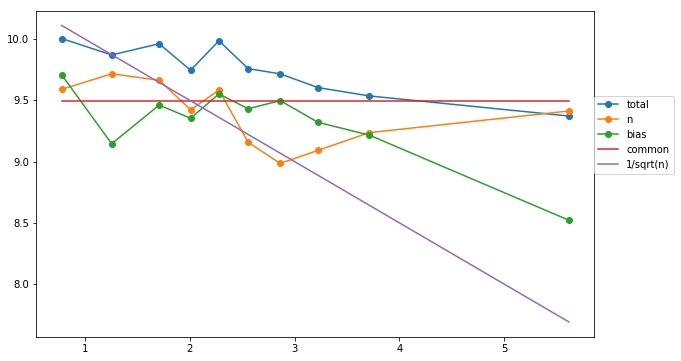

In [810]:
# 
fig, ax = plt.subplots(1, figsize = (10, 6))

plt.plot(lognqs, np.log10(np.sqrt(np.diag(yqs.T.cov().values))), marker = 'o', label = 'total') # actual std of quantiles
plt.plot(lognqs, np.log10(np.sqrt(np.diag(noise_qs.T.cov().values))), marker = 'o', label = 'n') # std of statistical noise
plt.plot(lognqs, np.log10(np.sqrt(np.diag(base_qs.T.cov().values))), marker = 'o', label = 'bias') # std of bias
plt.plot(lognqs, np.log10(np.sqrt(np.diag(common_R.T.cov().values))), label = 'common') # std of the common trend
plt.plot(lognqs, 10.5-lognqs/2, label = '1/sqrt(n)')
plt.legend(loc = (1, .5))
plt.show()

In [841]:
## Same plot but bootstrapped. Also, allow smaller s.
out_list = []

n = 50
Q = 10

for m in range(n):
    print(m)
    for s in [.02, .05, .1, .25, .5]:

        df_bs = sales.sample(frac = .5)
        df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

        logsales = np.log10(df_bs)

        micro_s = logsales.sub(logsales.mean(1), axis=0).unstack().std()
        zero_shock = logsales.notna().multiply(logsales.mean(1), axis = 0).replace(0, np.nan)
        simu_shocks = (s/micro_s)*logsales.sub(logsales.mean(1), axis = 0)

        total = np.power(10, zero_shock + simu_shocks)
        base = np.power(10, zero_shock)
        noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)
        
        total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))


        common_R = noise.groupby(total['q']).sum().median()
        # optional, broadcast to 2d Q x T
        common_R = pd.DataFrame(np.outer(np.ones(Q), common_R.values), columns=common_R.index)

        noise_qs = noise.groupby(total['q']).sum() - common_R
        base_qs = base.groupby(total['q']).sum()
        yqs = common_R + noise_qs + base_qs
        
        nqs = total['q'].value_counts().values
#         lognqs = np.log10(nqs)
        
        out = pd.concat([yqs.var(1), noise_qs.var(1), base_qs.var(1), common_R.var(1)], axis = 1)
        out.columns = ['yqs_var', 'noise_var', 'base_var', 'common_R_var']
        out['q'] = range(Q); out['m'] = m; out['nqs'] = nqs; out['s'] = s;

        out_list += [out]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [842]:
bs_result = pd.concat(out_list)

In [843]:
# data = bs_result.groupby(['q', 's']).agg(['mean', 'std']).drop('m', axis = 1)
data = bs_result.groupby(['q', 's']).median().drop('m', axis = 1)

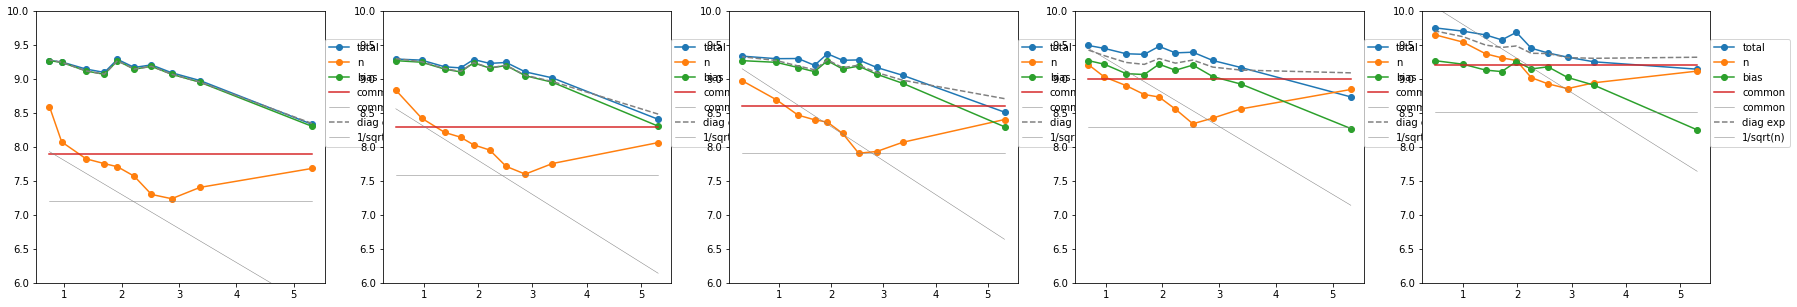

In [851]:
fig, axs = plt.subplots(1, 5, figsize = (30, 5))


for i, s in enumerate([.02, .05, .1, .25, .5]):
    ax = axs[i]
    data_s = data.loc[data.index.get_level_values('s') == s]
    lognqs = np.log10(data_s.nqs).values

    ax.plot(lognqs, np.log10(np.sqrt(data_s['yqs_var'].values)), marker = 'o', label = 'total') # actual std of quantiles
    ax.plot(lognqs, np.log10(np.sqrt(data_s['noise_var'].values)), marker = 'o', label = 'n') # std of statistical noise
    ax.plot(lognqs, np.log10(np.sqrt(data_s['base_var'].values)), marker = 'o', label = 'bias') # std of bias
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values)), label = 'common') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values) /5), label = 'common', lw = .5, c = '.5') # std of the common trend
    ax.plot(lognqs, np.log10(np.sqrt(data_s['common_R_var'].values + data_s['base_var'].values + data_s['noise_var'].values)), linestyle = '--', c = '.5', label = 'diag exp') # std of the common trend
    ax.plot(lognqs, .5*i + 8.3-lognqs/2, label = '1/sqrt(n)', lw = .5, c = '.5')
    ax.legend(loc = (1, .5))
    ax.set_ylim(7, 10)
plt.show()

In [747]:
# pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[Q:2*Q, :Q] - pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[:Q, Q:2*Q].T # == 0

# != 0
#  pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[Q:2*Q, :Q] +  pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[:Q, Q:2*Q] - 2 * pd.concat([common_R, base_qs, noise_qs]).T.cov().iloc[Q:2*Q, :Q]

In [748]:

show = (EV3*1e-19).round(1)
s = show.style.background_gradient(cmap=cm)
display(s)

,0,1,2,3,4,5,6,7,8,9
0,0.6,0.6,0.5,0.4,0.4,0.9,0.1,0.7,-0.2,0.9
1,0.6,1.2,1.3,1.6,1.7,3,1.3,2.7,1.3,3
2,0.5,1.3,1.6,2,2.2,3.7,1.7,3.4,1.9,3.6
3,0.4,1.6,2,2.7,2.8,4.9,2.2,4.6,2.7,4.7
4,0.4,1.7,2.2,2.8,3.3,5.2,2.2,5,3,5.2
5,0.9,3,3.7,4.9,5.2,9.4,3.7,8.6,4.4,9.4
6,0.1,1.3,1.7,2.2,2.2,3.7,3.1,3.3,3.1,3.6
7,0.7,2.7,3.4,4.6,5,8.6,3.3,8.4,3.9,8.9
8,-0.2,1.3,1.9,2.7,3,4.4,3.1,3.9,5.5,3.4
9,0.9,3,3.6,4.7,5.2,9.4,3.6,8.9,3.4,10.2


In [749]:
# yqs

show = (EV3*1e-19 - yqs.T.cov()*1e-19).round(1)
s = show.style.background_gradient(cmap=cm)
display(s)

,0,1,2,3,4,5,6,7,8,9
0,0,0,-0,-0,-0,-0,-0,-0,-0,-0
1,0,0,0,0,0,0,0,0,0,0
2,-0,0,0,-0,-0,0,-0,0,-0,0
3,-0,0,-0,-0,-0,-0,-0,-0,-0,-0
4,-0,0,-0,-0,-0,-0,-0,-0,-0,-0
5,-0,0,0,-0,-0,0,-0,0,0,0
6,-0,0,-0,-0,-0,-0,-0,-0,-0,-0
7,-0,0,0,-0,-0,0,-0,-0,0,0
8,-0,0,-0,-0,-0,0,-0,0,0,0
9,-0,0,0,-0,-0,0,-0,0,0,-0


In [602]:
# out_list = []
qs_bs_list = []
parts_bs_list = []
# nq_list = []
# trend_std_list = []

n = 10
Q = 10

for m in range(n):
    for s in [.02, .05, .1]:#, .25, .5]:

        df_bs = sales.sample(frac = .5)
        df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting
    
    #     Apply microshock magnification
        # Replace micro shocks. they will have and expected std(log()) == s
        df_scaled = df_bs.copy()
        df_scaled = np.log10(df_scaled)

        micro_s = df_scaled.sub(df_scaled.mean(1), axis=0).unstack().std()
        zero_shock = df_scaled.notna().multiply(df_scaled.mean(1), axis = 0).replace(0, np.nan)
        simu_shocks = (s/micro_s)*df_scaled.sub(df_scaled.mean(1), axis=0)

        # Done     
        
        total = np.power(10, zero_shock + simu_shocks)
        base = np.power(10, zero_shock)
        noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)

        total['q'] = pd.cut(total.sum(1).cumsum(), Q, labels = range(Q))

        total_q = total.groupby(total['q']).sum()
        base_q = base.groupby(total['q']).sum()
        noise_q = noise.groupby(total['q']).sum()
        
#         nq =  ## Effective nq
    #     nq = df_bs.q.value_counts()  ## Total count n
    
#         total_q = total.groupby('q').sum()

        common_trend = total_q.median()

        x = np.log10(common_trend).index.astype(int).values
        y = np.log10(common_trend).values
        z = np.polyfit(x, y, 1); p = np.poly1d(z);
        
        exp_curve = pd.Series(np.power(10, p(x)), index = x)

# #         df_bs = df_bs/(.5 * exp_curve)
#         shocks = common_trend/exp_curve
#         total_q_ = total_q/(shocks*exp_curve) # == df_bs/common_trend
#         base_q_ = base_q/(shocks*exp_curve) # == df_bs/common_trend
#         noise_q_ = noise_q/(shocks*exp_curve) # == df_bs/common_trend
        
#         shocks = common_trend/exp_curve
#         total_q_ = total_q/(exp_curve) # == df_bs/common_trend
#         base_q_ = base_q/(exp_curve) # == df_bs/common_trend
#         noise_q_ = noise_q/(exp_curve) # == df_bs/common_trend

        total_q_ = total_q
        base_q_ = base_q
        noise_q_ = noise_q


        parts_bs = pd.concat([exp_curve, shocks, base_q_.sum(), noise_q_.sum()], axis = 1).T; parts_bs.index = ['Line', 'Shocks', 'base', 'noise']; parts_bs.index.name = 'part'
        parts_bs['m'] = m; parts_bs['s'] = s
        parts_bs_list += [parts_bs]
        
        print(m)
        noise_q_['nq'] = total.groupby('q').count().mean(1); noise_q_['m'] = m; noise_q_['s'] = s;
        qs_bs_list += [noise_q_]
        
# #         trend_std_list += [np.log10(common_trend/np.power(10, p(x))).std()]


parts_bs = pd.concat(parts_bs_list).reset_index().set_index(['part', 's', 'm']).sort_index()
qs_bs = pd.concat(qs_bs_list)

0
0
0
1
1
1
2
2
2
3
3
3
4
4
4
5
5
5
6
6
6
7
7
7
8
8
8
9
9
9


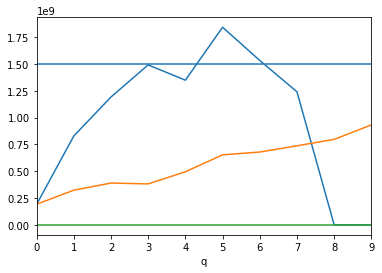

In [601]:
base_q.std(1).plot()
noise_q.std(1).plot()
plt.axhline(exp_curve.std())
noise_q_ = noise_q/(exp_curve)
noise_q_.std(1).plot()

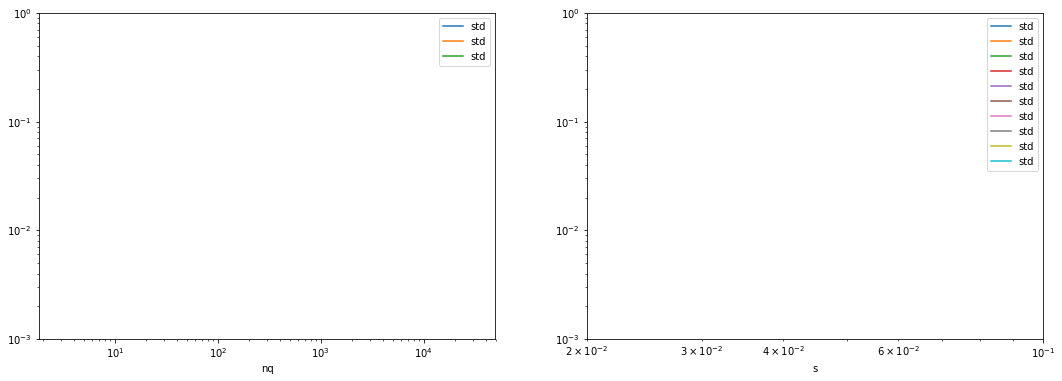

In [603]:
# qs_bs['std'] = np.log10(qs_bs[np.arange(1997, 2014)]).std(1)
qs_bs['std'] = qs_bs[np.arange(1997, 2014)].std(1)
grouped = qs_bs.reset_index().groupby(['q', 's'])

plot_data = qs_bs.reset_index().groupby(['q', 's'])[['nq', 'std']].median().reset_index()
plot_data

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

ax = axs[0]
for s in plot_data['s'].unique():
    plot_data.loc[plot_data.s == s].plot(x = 'nq', y = 'std', ax = ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(.001, 1)
    
ax = axs[1]
for q in plot_data['q'].unique():
    plot_data.loc[plot_data.q == q].plot(x = 's', y = 'std', ax = ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(.001, 1)
    

In [524]:
qs_bs['nq'] = qs_bs['nq'].round(1)

In [535]:
qs_bs.m.unique()

array([6])

In [538]:
qs_bs['std'] = np.log10(qs_bs[np.arange(1997, 2014)]).std(1)
grouped = qs_bs.reset_index().groupby(['q', 's'])

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


In [540]:
qs_bs

YEAR,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,...,2008,2009,2010,2011,2012,2013,nq,m,s,std
q,,,,,,,,,,,,,,,,,,,,,
0,-7.453473e+07,-3.959482e+07,-3.297641e+07,1.740314e+07,1.454499e+07,1.088592e+05,-1.363920e+07,-1.643493e+07,6.825696e+06,3.249170e+07,...,6.880114e+07,-2.781789e+07,2.750587e+07,4.700357e+07,6.143124e+07,6.766720e+07,49867.352941,0,0.02,0.814674
1,-1.550595e+08,-1.023016e+08,-7.379373e+07,-5.057829e+06,7.484816e+06,1.931432e+07,-2.218586e+05,2.077057e+07,1.204094e+07,5.798808e+07,...,8.771288e+07,-2.765807e+07,1.238043e+07,9.038169e+07,9.079122e+07,6.083377e+07,1884.176471,0,0.02,0.419213
2,-1.744444e+08,-1.093679e+08,-1.009204e+08,-4.320390e+07,-2.158713e+07,-1.264703e+07,3.384931e+05,-4.689247e+06,4.145138e+07,7.777929e+07,...,1.347639e+08,4.041159e+06,4.366722e+07,9.161655e+07,7.199560e+07,5.592597e+07,614.470588,0,0.02,0.814294
3,-1.736779e+08,-1.194593e+08,-1.045865e+08,-2.020576e+07,6.291633e+06,3.171991e+07,-5.849453e+07,1.197077e+07,-1.394795e+07,9.111664e+07,...,1.214084e+08,-1.452567e+07,5.901042e+07,1.472196e+08,1.093210e+08,3.168123e+07,264.882353,0,0.02,0.453213
4,-1.537093e+08,-6.839475e+07,-7.174302e+07,1.741775e+07,-5.349029e+06,2.317992e+07,-1.622957e+07,2.308990e+07,3.209673e+07,8.080497e+07,...,1.321278e+08,-6.202655e+07,5.869407e+07,9.822000e+07,4.551231e+07,-6.729840e+07,136.000000,0,0.02,0.321594
5,-1.567876e+08,-1.126000e+08,-1.288896e+08,-5.175005e+07,-2.408248e+07,8.114606e+05,-9.442554e+07,1.326629e+06,6.829683e+07,8.415522e+07,...,1.440881e+08,-5.888033e+07,7.875895e+07,1.342263e+08,1.217694e+08,5.327466e+07,70.882353,0,0.02,0.842538
6,-1.336493e+08,-1.330959e+07,-1.601996e+08,-8.132043e+07,4.265849e+07,7.377605e+07,4.542914e+07,1.408889e+08,1.064798e+08,1.182174e+08,...,1.676088e+08,-1.430479e+08,-2.731098e+07,2.317532e+07,-2.239570e+07,-8.446065e+07,43.117647,0,0.02,0.293088
7,-1.663527e+08,-1.375356e+08,-6.593506e+07,-2.605208e+07,1.486486e+07,-7.571262e+07,-3.206558e+07,7.563756e+06,1.169541e+05,2.756071e+07,...,1.211059e+08,3.044481e+07,1.130800e+08,1.068428e+08,8.631589e+07,-2.475283e+07,16.529412,0,0.02,0.916961
8,-6.745047e+08,-6.799684e+08,-8.118998e+06,9.402278e+07,9.067052e+07,2.803503e+07,-5.324029e+07,1.011307e+08,2.239228e+08,2.576721e+08,...,2.967704e+08,-2.913662e+08,1.280616e+08,1.898913e+08,2.316414e+08,1.923428e+08,7.000000,0,0.02,0.292793


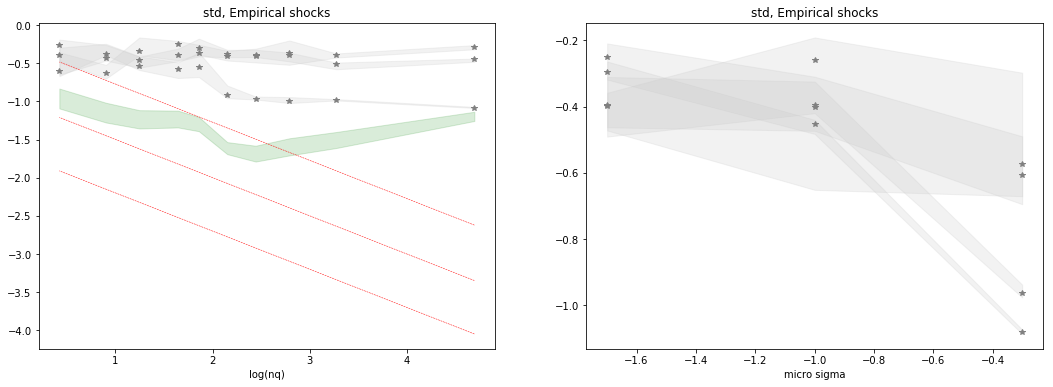

In [539]:
emp_plot_data = grouped['std'].median().unstack()
emp_plot_data_lo = grouped['std'].quantile(.25).unstack()
emp_plot_data_hi = grouped['std'].quantile(.75).unstack()
nqs = grouped['nq'].median().unstack().iloc[:, 0]

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

#################
    
ax = axs[0]
ax.set_title('std, Empirical shocks')

ax.set_xlabel('log(nq)')

for s in emp_plot_data.columns:
    ax.plot(np.log10(nqs), np.log10(emp_plot_data[s]), marker = '*', label = 'mu_q', color = '.5', lw = 0)
    ax.fill_between(np.log10(nqs), np.log10(emp_plot_data_hi[s]), np.log10(emp_plot_data_lo[s]), color = '.8', alpha = .25, label = 'common_shocks_std')
    
    ax.plot(np.log10(nqs), np.log10(np.sqrt((np.exp(s**2) - 1)/nqs)), color = 'r', linestyle = '--', zorder = 10, lw = .5)
ax.fill_between(np.log10(nqs), np.log10(emp_plot_data_hi_2.values.flatten()), np.log10(emp_plot_data_lo_2.values.flatten()), color = 'g', alpha = .15, label = 'common_shocks_std')

#################
    
ax = axs[1]
ax.set_title('std, Empirical shocks')

emp_plot_data.index = range(Q)

for q in emp_plot_data.index[::3]:
    ax.plot(np.log10(emp_plot_data.columns), np.log10(emp_plot_data.loc[q]), marker = '*', label = 'mu_q', color = '.5', lw = 0)
    ax.fill_between(np.log10(emp_plot_data.columns), np.log10(emp_plot_data_hi.loc[q]), np.log10(emp_plot_data_lo.loc[q]), color = '.8', alpha = .25, label = 'common_shocks_std')

ax.set_xlabel('micro sigma')

plt.show()

In [446]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

In [503]:
stacked_cov = parts_bs.T.cov().stack([-3, -2, -1])
stacked_cov.index.names = ['part1', 's1', 'm1', 'part2', 's2', 'm2']
stacked_cov_same_exp = stacked_cov.loc[(stacked_cov.index.get_level_values('m1') == stacked_cov.index.get_level_values('m2')) &
                                      (stacked_cov.index.get_level_values('s1') == stacked_cov.index.get_level_values('s2'))] # same experiment
cov_same_exp = stacked_cov_same_exp.groupby(level = ['part1', 's1', 'part2', 's2']).mean()#.unstack([-2, -1])


for s in cov_same_exp.index.get_level_values('s1').unique():
    print(s)
    cov_same_exp_s = cov_same_exp.loc[cov_same_exp.index.get_level_values('s1') == s]
    cov_same_exp_s.index = cov_same_exp_s.index.droplevel(['s1', 's2'])
    show = cov_same_exp_s.unstack()
    show = show.loc[(show.index != 'Line'), (show.columns != 'Line')].round(3)

    s = show.style.background_gradient(cmap=cm)
    display(s)

0.02


part2,Shocks,base,noise
part1,,,
Shocks,0.001,-0.003,0.001
base,-0.003,0.045,-0.006
noise,0.001,-0.006,0.006


0.05


part2,Shocks,base,noise
part1,,,
Shocks,0.002,-0.007,0.004
base,-0.007,0.075,-0.045
noise,0.004,-0.045,0.037


0.1


part2,Shocks,base,noise
part1,,,
Shocks,0.002,-0.013,0.008
base,-0.013,0.18,-0.123
noise,0.008,-0.123,0.115


0.2


part2,Shocks,base,noise
part1,,,
Shocks,0.004,-0.025,0.02
base,-0.025,0.551,-0.475
noise,0.02,-0.475,0.445


0.5


part2,Shocks,base,noise
part1,,,
Shocks,0.005,-0.031,0.027
base,-0.031,0.357,-0.356
noise,0.027,-0.356,0.462


part2,Line,Shocks,base,noise
part1,,,,
Line,5.865291e+18,-1.664550e+06,-7.810664e+08,1.006116e+09
Shocks,-1.664550e+06,4.594333e-03,-3.119226e-02,2.747361e-02
base,-7.810664e+08,-3.119226e-02,3.571102e-01,-3.560284e-01
noise,1.006116e+09,2.747361e-02,-3.560284e-01,4.619447e-01


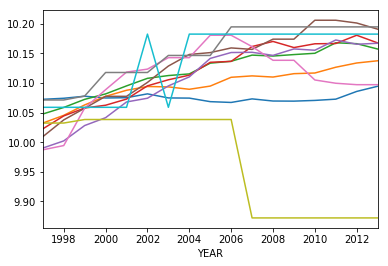

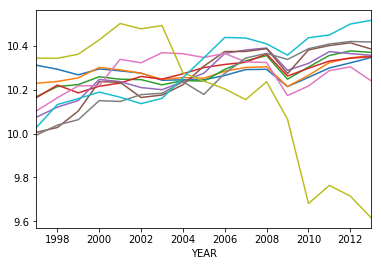

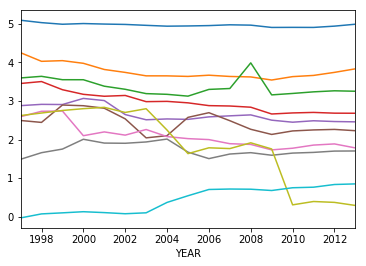

In [405]:
np.log10(np.power(10, zero_shock).groupby(df_bs['q']).sum()).T.plot(legend = False)

np.log10(np.power(10, zero_shock + simu_shocks).groupby(df_bs['q']).sum()).T.plot(legend = False)

np.log10(np.power(10, simu_shocks).groupby(df_bs['q']).sum()).T.plot(legend = False)

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


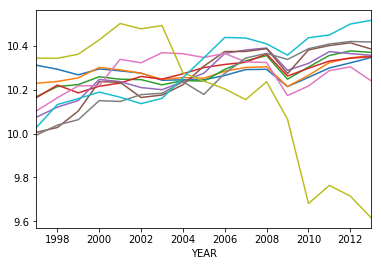

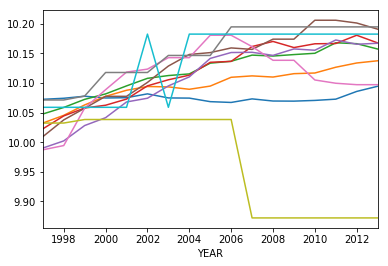

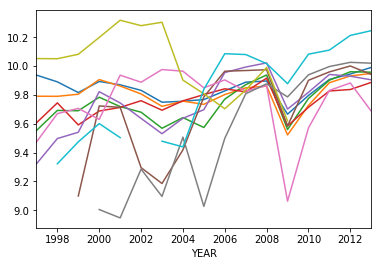

In [406]:
np.log10(( np.power(10, zero_shock + simu_shocks)).groupby(df_bs['q']).sum()).T.plot(legend = False)

np.log10(np.power(10, zero_shock).groupby(df_bs['q']).sum()).T.plot(legend = False)

np.log10((np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)).groupby(df_bs['q']).sum()).T.plot(legend = False)


In [407]:
np.log10((np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)).groupby(df_bs['q']).sum())

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


YEAR,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
q,,,,,,,,,,,,,,,,,
0,9.937797,9.890866,9.816690,9.893519,9.870517,9.832055,9.749711,9.756063,9.768188,9.828061,9.888684,9.896914,9.666640,9.796846,9.907509,9.945320,9.991054
1,9.791161,9.790518,9.805153,9.906686,9.861896,9.807150,9.721008,9.756794,9.735034,9.802804,9.849231,9.861667,9.522428,9.727370,9.885227,9.931876,9.949315
2,9.553146,9.692590,9.690466,9.784307,9.719171,9.680317,9.568866,9.642929,9.574124,9.770978,9.871267,9.938652,9.560373,9.775439,9.902662,9.960860,9.958052
3,9.606579,9.745061,9.592198,9.688557,9.713604,9.760065,9.694190,9.759420,9.802405,9.842664,9.821434,9.916882,9.584646,9.714583,9.827756,9.837808,9.887223
4,9.321911,9.497655,9.541191,9.822530,9.744741,9.637375,9.531076,9.638134,9.697744,9.955280,9.993534,10.022472,9.701870,9.818525,9.942189,9.930126,9.904981
5,NaN,NaN,9.098868,9.723774,9.713969,9.295784,9.185565,9.418828,9.786249,9.964706,9.969567,9.975090,9.584509,9.901816,9.959989,10.001051,9.942223
6,9.473390,9.670425,9.706579,9.630174,9.937333,9.888380,9.976340,9.964905,9.849325,9.904414,9.827054,9.864586,9.063002,9.571558,9.831632,9.883022,9.687293
7,NaN,NaN,NaN,9.004853,8.946744,9.285431,9.095852,9.507141,9.026946,9.498854,9.808211,9.877219,9.786463,9.939544,9.997307,10.026339,10.020467
8,10.052470,10.051408,10.082281,10.199188,10.318446,10.280960,10.304407,9.902869,9.808323,9.704168,9.834093,9.990459,9.619887,NaN,NaN,NaN,NaN


In [ ]:
total =  quantile bases: [ np.power(10, zero_shock) ]  +  quantile noises: [ np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock) ] = line + shocks + quantiles

In [423]:
total = np.power(10, zero_shock + simu_shocks)
base = np.power(10, zero_shock)
noise = np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)

total_q = total.groupby(df_bs['q']).sum()
base_q = base.groupby(df_bs['q']).sum()
noise_q = noise.groupby(df_bs['q']).sum()

q = 5
print(total_q.iloc[q].var())
print(pd.concat([noise_q.iloc[q], base_q.iloc[q]], axis = 1).cov().sum().sum())

2.8098784379738448e+19
2.8098784379738448e+19


0


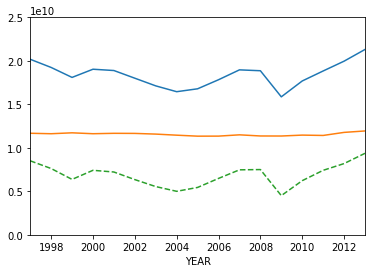

1


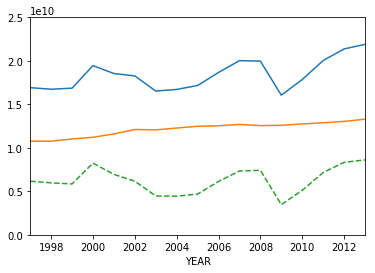

2


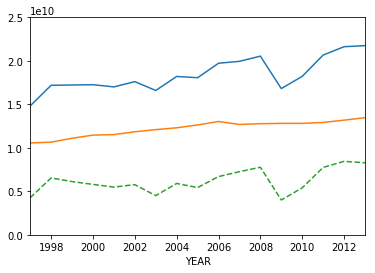

3


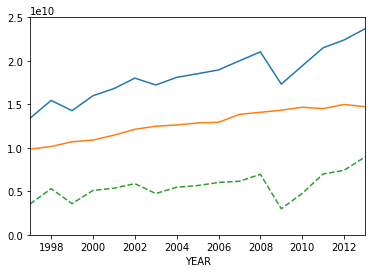

4


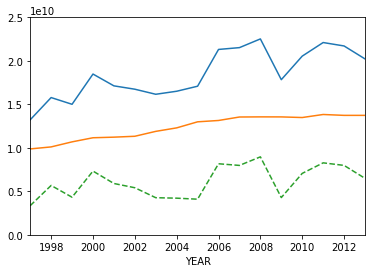

5


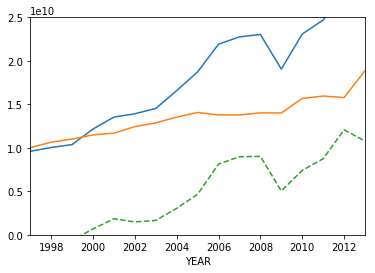

6


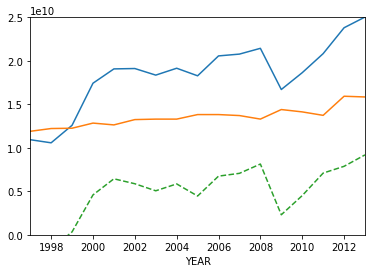

7


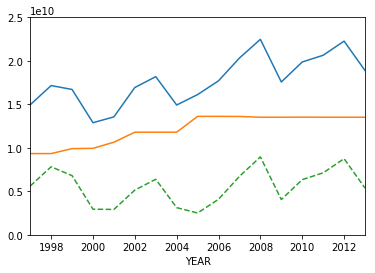

8


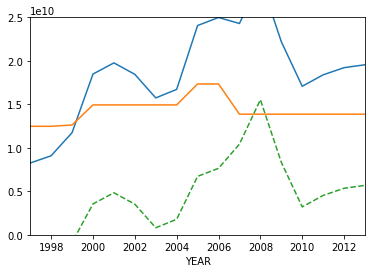

9


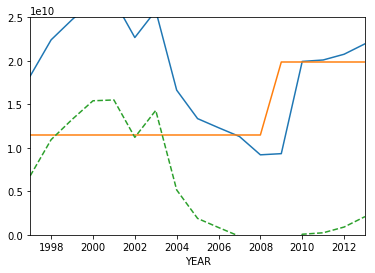

In [575]:
for q in range(Q):
    print(q)
    (( np.power(10, zero_shock + simu_shocks)).groupby(total['q']).sum()).iloc[q].plot()#.T.plot(legend = False)

    (np.power(10, zero_shock).groupby(total['q']).sum()).iloc[q].plot()#.T.plot(legend = False)

    ((np.power(10, zero_shock + simu_shocks) - np.power(10, zero_shock)).groupby(total['q']).sum()).iloc[q].plot(linestyle = '--')#.T.plot(legend = False)
    plt.ylim(0, 2.5e10)

    plt.show()

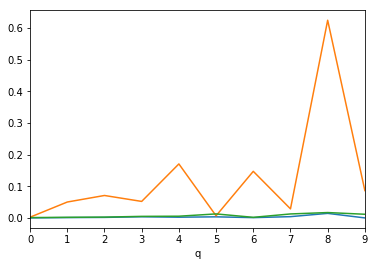

In [357]:
# I am doing: 
# np.power(10, zero_shock) * np.power(10, simu_shocks)

np.log10(np.power(10, zero_shock).groupby(df_bs['q']).sum()).var(1).plot()

np.log10(np.power(10, simu_shocks).groupby(df_bs['q']).sum()).var(1).plot()

np.log10(np.power(10, zero_shock + simu_shocks).groupby(df_bs['q']).sum()).var(1).plot()

# np.power(10, simu_shocks).groupby(df_bs['q']).sum().round(-2)

In [351]:
simu_shocks.loc[df_bs['q'] == 5]

YEAR,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
ID,,,,,,,,,,,,,,,,,
562111997,4.569663,4.851669,4.811896,0.531343,-0.081092,-1.008219,3.135090,-0.718261,-1.013847,-1.279122,-1.999445,-2.607846,-1.119511,-0.992137,-1.935449,-4.097510,-1.047221
398796383,0.064892,0.015243,0.017838,-0.067879,-0.039529,0.075975,0.254506,0.387038,0.269094,-0.089948,-0.097790,-0.075095,-0.154232,-0.190989,-0.153319,-0.237643,0.021839
411669823,-1.291732,-0.000750,0.210568,-0.025438,0.342698,0.253763,0.407092,0.497689,0.561946,-0.955836,NaN,NaN,NaN,NaN,NaN,NaN,NaN
348975269,0.262773,0.376879,0.401396,0.520363,2.133428,2.159090,2.263620,2.526281,2.694648,2.359661,1.259242,-3.588496,-5.912361,NaN,-7.456524,NaN,NaN
420559056,NaN,NaN,NaN,-6.960179,-0.457657,0.258390,0.528779,0.621049,0.522096,0.954513,0.961842,0.893028,0.447744,0.399513,0.359940,0.763423,0.707520
410462857,-0.799636,0.551169,0.506327,0.516774,0.610497,0.533913,-0.288898,-0.086218,-0.247907,-1.296021,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316331065,-1.036246,-0.688029,-0.535270,-0.521564,-0.155080,0.052654,0.026718,-0.131278,-0.153380,-0.069653,0.063071,-0.036505,0.193783,0.348713,0.733115,0.950148,0.958804
423259381,NaN,NaN,-4.245937,-3.247118,-3.532221,-0.801855,0.031211,0.322749,0.330989,0.299810,1.191551,1.651124,1.526283,1.479386,1.484307,1.706139,1.803580
622037083,-2.522636,-2.488154,-2.428406,-0.623073,-0.471433,-0.390310,-0.486537,-0.501391,-0.474330,0.492996,1.518301,1.433119,1.065155,1.332965,1.524276,1.545994,1.473465


(0.01, 1)

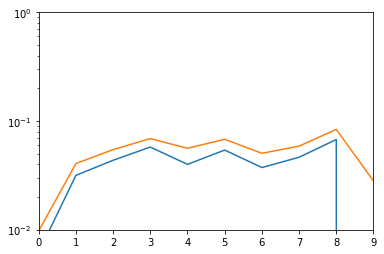

In [325]:


micro_shocks = df_scaled.sub(df_scaled.mean(1), axis=0)
# Done

df = zero_shock + micro_shocks
df = np.power(10, zero_shock + micro_shocks)

# df['q'] = pd.cut(df.sum(1).cumsum(), Q, labels = range(Q))

df_q = pd.cut(np.power(10, zero_shock).sum(1).cumsum(), Q, labels = range(Q))

np.log10(np.power(10, zero_shock).groupby(df_q).sum()).std(1).plot()
np.log10(np.power(10, zero_shock + (.05/micro_s)*micro_shocks).groupby(df_q).sum()).std(1).plot()

plt.yscale('log')
plt.ylim(.01, 1)

In [ ]:
## Non scaled, sanity check.

In [267]:
# out_list = []
qs_bs_list = []
parts_bs_list = []
# nq_list = []
# trend_std_list = []

n = 50
Q = 10

for m in range(n):

    df_bs = sales.sample(frac = .5)
    df_bs = df_bs.loc[df_bs.sum(1).sort_values().index] #sorting

    df_bs['q'] = pd.cut(df_bs.sum(1).cumsum(), Q, labels = range(Q))

    nq = df_bs.groupby('q').count().mean(1) ## Effective nq
#     nq = df_bs.q.value_counts()  ## Total count n

    df_bs = df_bs.groupby('q').sum()

    common_trend = df_bs.median()

    x = np.log10(common_trend).index.astype(int).values
    y = np.log10(common_trend).values
    z = np.polyfit(x, y, 1); p = np.poly1d(z);

    exp_curve = pd.Series(np.power(10, p(x)), index = x)

#         df_bs = df_bs/(.5 * exp_curve)
    shocks = common_trend/exp_curve
    df_bs = df_bs/(shocks*exp_curve) # == df_bs/common_trend

    parts_bs_2 = pd.concat([exp_curve, shocks, df_bs.sum()], axis = 1).T
    parts_bs_2['m'] = m; parts_bs_2['s'] = s
    parts_bs_list += [parts_bs_2]


    df_bs['nq'] = nq; df_bs['m'] = m; df_bs['s'] = s;
    qs_bs_list += [df_bs]

#         trend_std_list += [np.log10(common_trend/np.power(10, p(x))).std()]


parts_bs_2 = pd.concat(parts_bs_list)
qs_bs_2 = pd.concat(qs_bs_list)

In [175]:

## Microshocks

demlogsales['parts'] = parts
std_data = demlogsales.loc[demlogsales.iloc[:, :-1].count(1) > 1]
std_data.reset_index().set_index(['ID', 'parts']).stack().groupby(level = 'parts').std()


# Un array de donde samplear shocks empiricos.
emp_shocks = std_data.reset_index().set_index(['ID', 'parts']).stack().values
len(emp_shocks)

1615735

In [156]:

# demedianed_log10 = np.log10(bs_data/pd.concat(n*[bs_data.groupby(level = 0).median()]))
# var_nq = pd.concat([demedianed_log10.var(1), nq], axis = 1); var_nq.columns = ['var', 'nq']
# # quantile shocks

# qshocks = demedianed_log10.diff(axis = 1).stack().reset_index()
# qshocks['bin'] = pd.cut(qshocks[0], np.arange(-.1, .1, .001))

# qshocks_hist = pd.DataFrame(qshocks.groupby(['bin', 'q']).size().unstack())

# qshocks_hist.rolling(6, center = True).mean().plot(figsize = (7, 5), marker = '.')
# plt.yscale('log')
# plt.show()


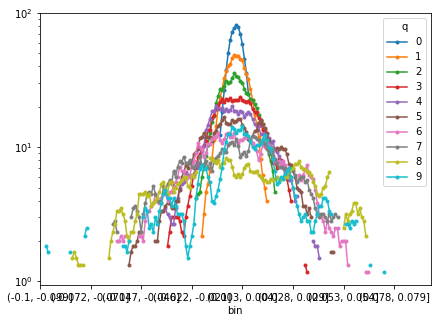

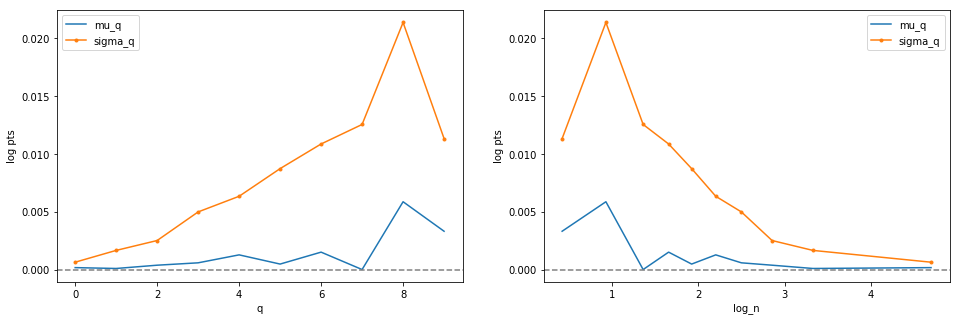

In [6]:

data = qshocks_hist.rolling(6, center = True).mean()
data = data.loc[[-.05 < m.mid < .05 for m in data.index]]

quad_params = []

for q in range(Q):
    x = [m.mid for m in data[q].dropna().index]
    y = data[q].dropna().values
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
#     print(p)
    quad_params += [z]
    
quad_params = np.array(quad_params)


# NQs from bootstrap
var_nq['m'] = [i//Q for i in range(n*Q)]
nq = var_nq.reset_index().set_index(['q', 'm'])['nq'].unstack().median(1)


fig, axs = plt.subplots(1, 2, figsize = (16, 5))

ax = axs[0]
ax.plot(range(Q), -quad_params[:, 1]/(2*quad_params[:, 0]), label = 'mu_q')
ax.plot(range(Q), 1/np.sqrt(-2*quad_params[:, 0]), marker = '.', label = 'sigma_q')
ax.set_xlabel('q'); ax.set_ylabel('log pts')
ax.axhline(0, c = '.5', linestyle = '--')
ax.legend()


ax = axs[1]
ax.plot(np.log10(nq.values), -quad_params[:, 1]/(2*quad_params[:, 0]), label = 'mu_q')
ax.plot(np.log10(nq.values), 1/np.sqrt(-2*quad_params[:, 0]), marker = '.', label = 'sigma_q')
ax.set_xlabel('log_n'); ax.set_ylabel('log pts')
ax.axhline(0, c = '.5', linestyle = '--')
ax.legend()

plt.show()

In [7]:
def percentile_lo (x): 
    return np.percentile(x, q=10)
def percentile_hi (x): 
    return np.percentile(x, q=90)

In [15]:
# emp_nqs = np.round(nq.sort_values()).astype(int)
partition = nq.astype(int)
ss = np.arange(0.1, .8, .1)
M = 25

T = 100

## Fit to theoretical deduction with "narrow bin" approximation

In [16]:

### Experiments (gaussian and laplace deviations from mean)

results = []

s0 = emp_shocks.std()

for dist in ['norm', 'lapl', 'emp']:
    for q in range(Q)[1:]:
        part = partition.index[q]
        n = partition.values[q]
#         x0 = np.log10(sizes.loc[parts == part]).values # comment for narrow bin limit
        print(q, n)
        for s in ss:
            for m in range(M):
                if dist == 'norm':
                    shocks = np.random.normal(0, s, (n, T))
                elif dist == 'lapl':
                    shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
                elif dist == 'emp':
                    shocks = (np.random.choice(emp_shocks, n * T)*(s/s0)).reshape(n, T)
                    
                values = np.log10(np.power(10, shocks).sum(0)/n) #M?
#                 values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M? # comment for narrow bin limit

#             t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]
                results += [[dist, s, n, m, values.mean(), values.std()]]

result = pd.DataFrame(results, columns = ['dist', 's', 'nq', 'repeat', 'mean', 'std'])


1 2116
2 712
3 314
4 158
5 83
6 45
7 22
8 8
9 2
1 2116
2 712
3 314
4 158
5 83
6 45
7 22
8 8
9 2
1 2116
2 712
3 314
4 158
5 83
6 45
7 22
8 8
9 2


### vs micro sigma

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in log10


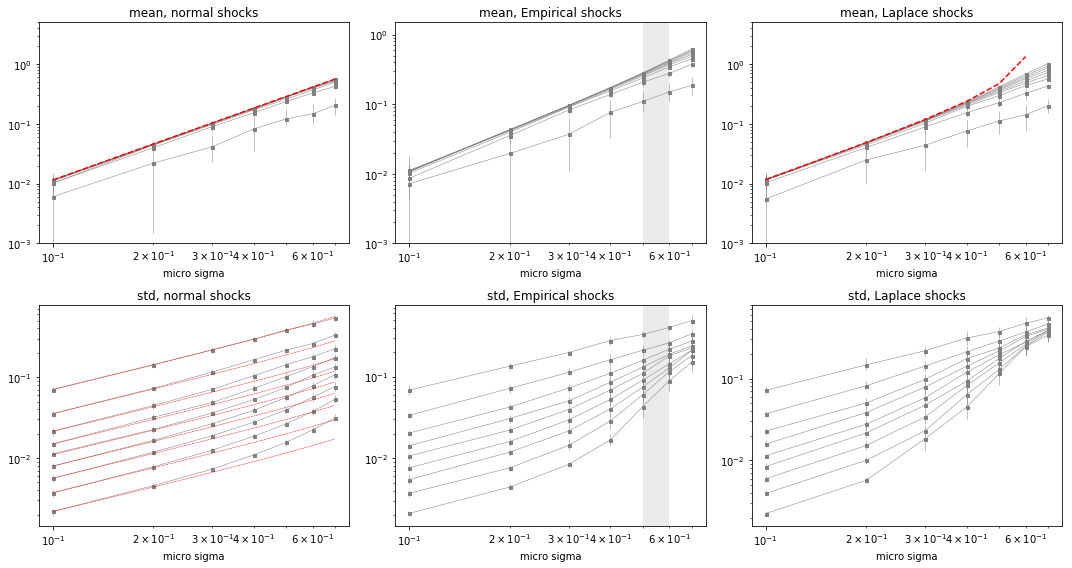

In [23]:

fig, axs = plt.subplots(2, 3, figsize = (15, 8))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]
ax.set_title('mean, normal shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
## Analytical expectation
ax.plot(x, x**2*np.log(10)/2, color = 'r', linestyle = '--', zorder = 10)

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
ax = axs[1][0]
ax.set_title('std, normal shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

## Analytical expectation
# for n0 in partition.values[1:]:
#     ax.plot(x, np.sqrt(np.exp(x**2)*(np.exp(x**2) - 1)/n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)
for n0 in partition.values[1:]:
    ax.plot(x, np.sqrt((np.exp(x**2) - 1)/n0), color = 'r', linestyle = '--', zorder = 10, lw = .5)

ax.set_xscale('log')
ax.set_yscale('log')
    
    
#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][1]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.axvspan(.5, .6, facecolor='.85', alpha=0.5)

ax.set_xlabel('micro sigma')

###
ax.set_yscale('log')
ax.set_ylim(.001, 1.5)
    
ax.set_xscale('log')

#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)

ax.axvspan(.5, .6, facecolor='.85', alpha=0.5)

ax.set_xlabel('micro sigma')

ax.set_xscale('log')
ax.set_yscale('log')


#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')


## Analytical expectation
ax.plot(x, np.log10(1/(1 - (x*np.log(10))**2/2)), color = 'r', linestyle = '--', zorder = 10)

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
    
ax = axs[1][2]
ax.set_title('std, Laplace shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_xlabel('micro sigma')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('./../../../WRITING/paper1_writing/figures/power_sums_vs_sigma.png')
plt.show()

### vs log(nq)

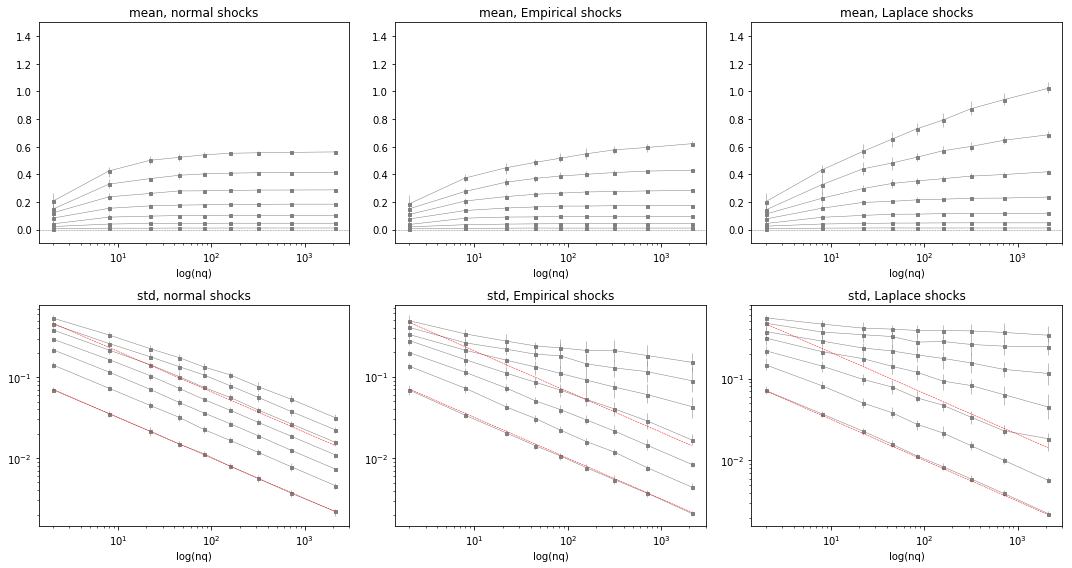

In [28]:

fig, axs = plt.subplots(2, 3, figsize = (15, 8))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]
ax.set_title('mean, normal shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
ax.set_xscale('log')
#################
ax = axs[1][0]
ax.set_title('std, normal shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][1]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')

ax.set_xscale('log')
#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values
for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 

ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
ax.set_xscale('log')

#################
    
ax = axs[1][2]
ax.set_title('std, Laplace shocks')

# logplot_data = np.log10(plot_data)
y_data = plot_data['std']['mean'].unstack()
yhi_data = plot_data['std']['percentile_hi'].unstack() - plot_data['std']['mean'].unstack()
ylo_data = plot_data['std']['mean'].unstack() - plot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')
ax.set_xscale('log')
ax.set_yscale('log')

for s0 in [0.1, 0.6]:
    ax.plot(x, np.sqrt((np.exp(s0**2) - 1)/x), color = 'r', linestyle = '--', zorder = 10, lw = .5)

plt.tight_layout()
plt.savefig('./../../../WRITING/paper1_writing/figures/power_sums_vs_nq.png')
    
plt.show()

In [ ]:
xx

## Repeat, non narrow bins, i.e. sizes in x0 used

### Bootstrap on empirical data

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [208]:
# bs_data = qs_bs.loc[qs_bs.s == .1].drop(['nq', 'm', 's'], axis = 1)

# # Empirical stds
# emp_std_lo = np.log10(bs_data).std(1).groupby(level = 0).quantile(.1)
# emp_std_mn = np.log10(bs_data).std(1).groupby(level = 0).mean()
# emp_std_hi = np.log10(bs_data).std(1).groupby(level = 0).quantile(.9)

# # Nqs
# emp_nq_med = nq.groupby(level = 0).median()



In [292]:
qs_bs_2['std'] = np.log10(qs_bs_2[np.arange(1997, 2014)]).std(1)
grouped_2 = qs_bs_2.reset_index().groupby(['q', 's'])

emp_plot_data_2 = grouped_2['std'].median().unstack()
emp_plot_data_lo_2 = grouped_2['std'].quantile(.25).unstack()
emp_plot_data_hi_2 = grouped_2['std'].quantile(.75).unstack()
nqs = grouped_2['nq'].median().unstack().iloc[:, 0]

In [293]:
# np.log10(emp_plot_data_hi_2.values.flatten())

/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


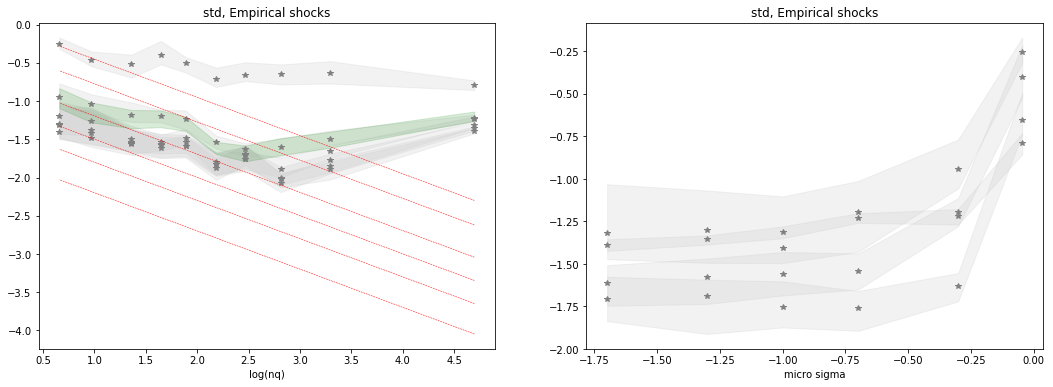

In [297]:
qs_bs['std'] = np.log10(qs_bs[np.arange(1997, 2014)]).std(1)
grouped = qs_bs.reset_index().groupby(['q', 's'])
emp_plot_data = grouped['std'].median().unstack()
emp_plot_data_lo = grouped['std'].quantile(.25).unstack()
emp_plot_data_hi = grouped['std'].quantile(.75).unstack()
nqs = grouped['nq'].median().unstack().iloc[:, 0]

fig, axs = plt.subplots(1, 2, figsize = (18, 6))

#################
    
ax = axs[0]
ax.set_title('std, Empirical shocks')

ax.set_xlabel('log(nq)')

for s in emp_plot_data.columns:
    ax.plot(np.log10(nqs), np.log10(emp_plot_data[s]), marker = '*', label = 'mu_q', color = '.5', lw = 0)
    ax.fill_between(np.log10(nqs), np.log10(emp_plot_data_hi[s]), np.log10(emp_plot_data_lo[s]), color = '.8', alpha = .25, label = 'common_shocks_std')
    
    ax.plot(np.log10(nqs), np.log10(np.sqrt((np.exp(s**2) - 1)/nqs)), color = 'r', linestyle = '--', zorder = 10, lw = .5)
ax.fill_between(np.log10(nqs), np.log10(emp_plot_data_hi_2.values.flatten()), np.log10(emp_plot_data_lo_2.values.flatten()), color = 'g', alpha = .15, label = 'common_shocks_std')

#################
    
ax = axs[1]
ax.set_title('std, Empirical shocks')

emp_plot_data.index = range(Q)

for q in emp_plot_data.index[::3]:
    ax.plot(np.log10(emp_plot_data.columns), np.log10(emp_plot_data.loc[q]), marker = '*', label = 'mu_q', color = '.5', lw = 0)
    ax.fill_between(np.log10(emp_plot_data.columns), np.log10(emp_plot_data_hi.loc[q]), np.log10(emp_plot_data_lo.loc[q]), color = '.8', alpha = .25, label = 'common_shocks_std')

ax.set_xlabel('micro sigma')

plt.show()

Float64Index([0.02, 0.05, 0.1, 0.2, 0.5, 0.9], dtype='float64', name='s')

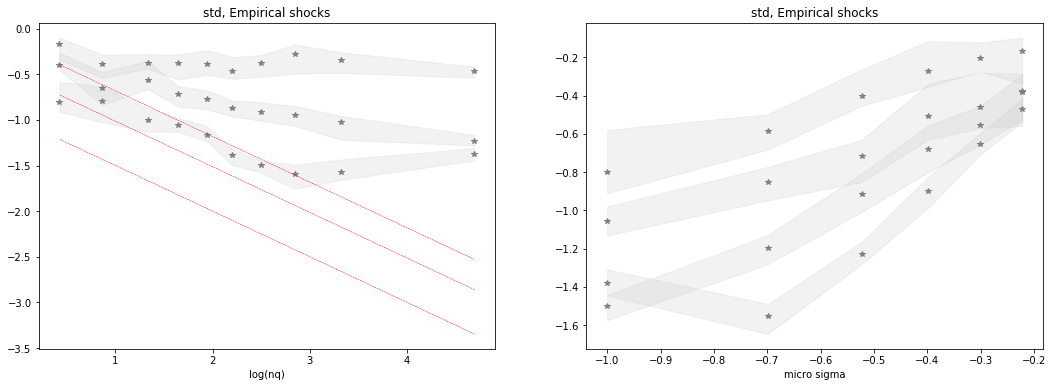

### Synthetic lognormal for x0

In [34]:
from scipy.stats import norm

#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 11.5% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))


N = int(emp_nq_med.sum().round())

N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
# From the theoretical N and the ppf we can know the theoretical quantiles
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

In [35]:
s0 = pd.Series(np.power(10, x_logn_clip3))

s0_n = s0.groupby(pd.cut(s0.cumsum()/s0.sum(), Q, labels = range(Q))).count()
bs_n = emp_nq_med.round(1)

show = pd.concat([bs_n, s0_n], axis = 1); show.columns = ['Bootstrap nq', 'Lognormal >3 synthetic dist']
show

,Bootstrap nq,Lognormal >3 synthetic dist
0,49330.1,49518
1,2116.2,1989
2,712.9,685
3,314.6,303
4,158.8,150
5,83.6,76
6,45.2,40
7,22.9,20
8,8.5,10
9,2.6,4


### Computation of variance

In [36]:
emp_nqs = np.round(nq.sort_values()).astype(int)
ss = np.arange(0.1, .8, .1)
M = 20

T = 17

In [37]:
### Experiments (gaussian and laplace deviations from mean)
partition_df = s0_n # index are quantile ixs and value has their n.

results = []

sigma0 = emp_shocks.std()

for dist in ['emp']:
    for q in range(Q):
        part = partition_df.index[q]
        n = partition_df.round().astype(int).values[q]
        x0 = pd.Series(x_logn_clip3).loc[pd.cut(s0.cumsum()/s0.sum(), Q, labels = range(Q)) == part].values
#         print(q, n)
        for s in ss:
            for m in range(M):
                if dist == 'norm':
                    shocks = np.random.normal(0, s, (n, T))
                elif dist == 'lapl':
                    shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
                elif dist == 'emp':
                    shocks = (np.random.choice(emp_shocks, n * T)*(s/sigma0)).reshape(n, T)
                    
#                 values = np.log10(np.power(10, shocks).sum(0)/n) #M?
                values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M?
                results += [[dist, s, n, m, values.mean(), values.std()]]

result = pd.DataFrame(results, columns = ['dist', 's', 'nq', 'repeat', 'mean', 'std'])


/home/miglesia/anaconda2/envs/my_pymc_env/lib/python3.6/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log10


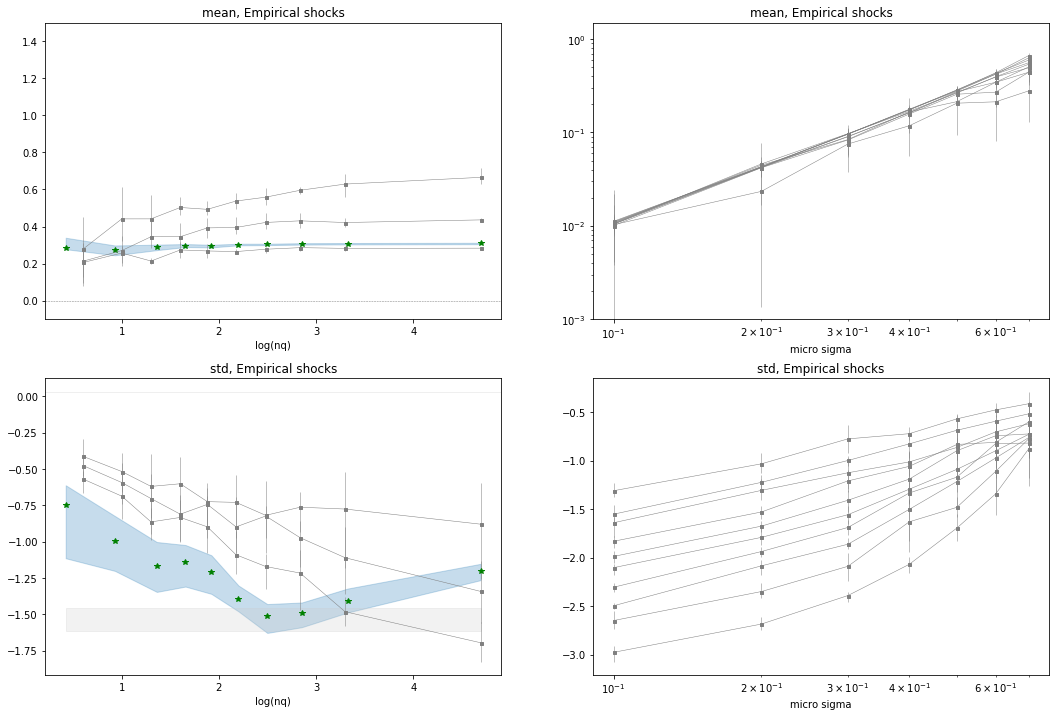

In [38]:

fig, axs = plt.subplots(2, 2, figsize = (18, 12))

#################
# Empirical Shocks
plot_data = result.loc[(result.dist == 'emp') & (result.s >= .5)].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][0]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
# Empirical
ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

#################
    
ax = axs[1][0]
ax.set_title('std, Empirical shocks')

logplot_data = np.log10(plot_data)
y_data = logplot_data['std']['mean'].unstack()
yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
x = np.log10(y_data.columns.values)

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# Empirical
ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

ax.fill_between(np.log10(emp_nq_med), np.log10(np.quantile(trend_std, .9)), np.log10(np.quantile(trend_std, .1)), color = '.8', alpha = .25, label = 'common_shocks_std')
ax.axhline(np.mean(trend_std), color = '.5', alpha = .25, lw = .5, label = 'common_shocks_std')

# sqrt(sobs2 - (strend)2) = (sq)
# ax.plot(np.log10(emp_nq_med), np.log10(np.sqrt(emp_std_mn**2 - np.median(trend_std)**2))) 


#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][1]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')

###
ax.set_yscale('log')
ax.set_ylim(.001, 1.5)
    
ax.set_xscale('log')

#################
    
ax = axs[1][1]
ax.set_title('std, Empirical shocks')

logplot_data = np.log10(plot_data)
y_data = logplot_data['std']['mean'].unstack()
yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

ax.set_xscale('log')

plt.show()

In [ ]:
xx

In [ ]:

fig, axs = plt.subplots(2, 3, figsize = (27, 12))

#################
# Normal
plot_data = result.loc[result.dist == 'norm'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()

ax = axs[0][0]
ax.set_title('mean, normal shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
## Analytical expectation
ax.plot(x, x**2*np.log(10)/2, color = 'r', linestyle = '--', zorder = 10)

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
ax = axs[1][0]
ax.set_title('std, normal shocks')

logplot_data = np.log10(plot_data)
y_data = logplot_data['std']['mean'].unstack()
yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

## Analytical expectation
for n0 in emp_nqs:
    ax.plot(x, np.log10(np.sqrt(np.exp(x**2)*(np.exp(x**2) - 1)/n0)), color = 'r', linestyle = '--', zorder = 10, lw = .5)

ax.set_xscale('log')

    
#################
# Laplace
plot_data = result.loc[result.dist == 'lapl'].groupby(['nq','s'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][1]
ax.set_title('mean, Laplace shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')


## Analytical expectation
ax.plot(x, np.log10(1/(1 - (x*np.log(10))**2/2)), color = 'r', linestyle = '--', zorder = 10)

###
ax.set_yscale('log')
ax.set_ylim(.001, 5)

ax.set_xscale('log')


#################
    
ax = axs[1][1]
ax.set_title('std, Laplace shocks')

logplot_data = np.log10(plot_data)
y_data = logplot_data['std']['mean'].unstack()
yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_xlabel('micro sigma')

ax.set_xscale('log')


#################
# Empirical Shocks
plot_data = result.loc[result.dist == 'emp'].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()


ax = axs[0][2]
ax.set_title('mean, Empirical shocks')

y_data = plot_data['mean']['mean'].unstack()
yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')

###
ax.set_yscale('log')
ax.set_ylim(.001, 1.5)
    
ax.set_xscale('log')

#################
    
ax = axs[1][2]
ax.set_title('std, Empirical shocks')

logplot_data = np.log10(plot_data)
y_data = logplot_data['std']['mean'].unstack()
yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
x = y_data.columns.values

for s in y_data.index.values:
    ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

ax.set_xscale('log')

plt.show()

In [ ]:
### Proximos testeos: size distribution...

In [ ]:
# Para ellos, es todo igual, nomas que hay una distribucion de sizes, los shocks se agregan a ellas y se divide por (X/Q) en vez de (s0*n)

 ### Size distributions

In [33]:
from scipy.stats import norm
from scipy.stats import pareto
from scipy.special import erf

# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.2810683494198207 # 1.3149476902828778
mu = 4.536908110675739 # 4.470439741406725
# 11.5% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# We'll try different N's, until we can match the avg level of France imports 

N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

# From the theoretical N and the ppf we can know the theoretical quantiles
x_logn_clip3 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x_logn_clip3 = x_logn_clip3[(-N - 1):-1]

## N tail for pareto and lognormal tail
N_tail = get_n(x_logn_clip3, 10)[1][1:].sum()

n = N_tail
x_logn_clip3_90 = x_logn_clip3[-N_tail:]

# PARETO
z_0 = -1.1042021 #-1.1771
# value_qs_1 = x_logn_clip3_90.min() # 6.761 in the original fit
value_qs_1 = 6.67465

norm = 1.375
x1 = np.array([pareto.ppf(b = -z_0, scale = 10**value_qs_1, q = q) for q in np.arange(0, 1, 1/(norm*N_tail)) + .5/(norm*N_tail)])
np.log10(pareto.rvs(b = -z_0, size = n, scale = 10**value_qs_1) + 1)
x1 = x1[int(-norm*N_tail - 1):-1]

x_pareto = np.log10(x1)

In [ ]:
emp_nqs = np.round(nq.sort_values()).astype(int)
ss = np.arange(0.1, .8, .2)
M = 10

T = 17

In [ ]:
### Experiments (gaussian and laplace deviations from mean)

results = []


for dist in ['norm', 'lapl']:
    for j, size_dist in enumerate([x_logn_clip3, x_logn_clip3_90, x_pareto]):
        sdist_name = ['Logn', 'Logn90', 'Pareto'][j]
        bins, partition_ns = get_n(size_dist, Q)
        for q, part in enumerate(bins.unique()):
            x0 = pd.Series(size_dist).loc[bins == part].values
            n = partition_ns[q]
            for s in ss:
                for m in range(M):
                    if dist == 'norm':
                        shocks = np.random.normal(0, s, (n, T))
                    elif dist == 'lapl':
                        shocks = np.random.laplace(0, s, (n, T))/np.sqrt(2)
    #                 values = np.log10(np.power(10, shocks).sum(0)/n) #M?
                    # same as before but now x0 is a vector of sizes in the quantile, determined by the size dist, N and the Q chosen.
                    values = np.log10(np.power(10, x0[:, None] + shocks).sum(0)/np.power(10, x0[:, None]).sum(0)) #M?
    #             t += [np.power(10, x0 + x1).sum()/(n*10**mu0)]


                    results += [[dist, sdist_name, s, n, m, values.mean(), values.std()]]

sdist_result = pd.DataFrame(results, columns = ['dist', 'size_dist', 's', 'nq', 'repeat', 'mean', 'std'])


In [ ]:

fig, axs = plt.subplots(2, 2, figsize = (18, 12))

#################
# Normal
ax = axs[0][0]
ax.set_title('mean, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
# #################
ax = axs[1][0]
ax.set_title('std, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
# # Laplace

ax = axs[0][1]
ax.set_title('mean, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)

ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('log(nq)')
    
# # Empirical
# ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
    
ax = axs[1][1]
ax.set_title('std, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['s','nq'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('log(nq)')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

plt.show()

In [ ]:

fig, axs = plt.subplots(2, 2, figsize = (18, 12))

#################
# Normal
ax = axs[0][0]
ax.set_title('mean, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
    
ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
# #################
ax = axs[1][0]
ax.set_title('std, normal shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'norm')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
# # Laplace

ax = axs[0][1]
ax.set_title('mean, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    
    y_data = plot_data['mean']['mean'].unstack()
    yhi_data = plot_data['mean']['percentile_hi'].unstack() - plot_data['mean']['mean'].unstack()
    ylo_data = plot_data['mean']['mean'].unstack() - plot_data['mean']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)

ax.set_ylim(-.1, 1.5)
ax.axhline(0, color = '.5', lw = .5, linestyle = '--')
ax.set_xlabel('micro sigma')
    
# # Empirical
# ax.fill_between(np.log10(emp_nq_med), emp_mean_hi, emp_mean_lo, color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), emp_mean_mn, marker = '*', label = 'mu_q', color = 'g', lw = 0)

# #################
    
ax = axs[1][1]
ax.set_title('std, Laplace shocks')

for sdist in ['Logn', 'Logn90', 'Pareto']:
    plot_data = sdist_result.loc[(sdist_result.size_dist == sdist) & (sdist_result.dist == 'lapl')].groupby(['nq', 's'])[['mean', 'std']].agg([np.mean, percentile_lo, percentile_hi])#.reset_index()
    logplot_data = np.log10(plot_data)
    y_data = logplot_data['std']['mean'].unstack()
    yhi_data = logplot_data['std']['percentile_hi'].unstack() - logplot_data['std']['mean'].unstack()
    ylo_data = logplot_data['std']['mean'].unstack() - logplot_data['std']['percentile_lo'].unstack()
    x = np.log10(y_data.columns.values)

    for s in y_data.index.values:
        ax.errorbar(x, y_data.loc[s], yerr=[ylo_data.loc[s], yhi_data.loc[s]], lw = .5, color = '.5', marker = 's', markersize = 3)
ax.set_xlabel('micro sigma')

# # Empirical
# ax.fill_between(np.log10(emp_nq_med), np.log10(emp_std_hi), np.log10(emp_std_lo), color = '#1f77b4', alpha = .25, label = 'empirical')
# ax.plot(np.log10(emp_nq_med), np.log10(emp_std_mn), marker = '*', label = 'mu_q', color = 'g', lw = 0)

plt.show()